# Skfolio: The Latest Python Library for Portfolio Optimization

## Setup

In [1]:
import requests
import pandas as pd
import numpy as np

from skfolio import PerfMeasure, RatioMeasure, RiskMeasure, Population
from skfolio.optimization import (
    MeanRisk,
    ObjectiveFunction,
)
from skfolio.preprocessing import prices_to_returns

# plotting
from plotly.io import show
import seaborn as sns 
import matplotlib.pyplot as plt

# settings
plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams["figure.figsize"] = (16, 8)

# api key
from api_keys import FMP_API_KEY

## Downloading data

In [2]:
FAANG_TICKERS = ["META", "AAPL", "AMZN", "NFLX", "GOOGL"]
START_DATE = "2023-08-01"

In [3]:
def get_adj_close_price(symbol, start_date):
    hist_price_url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start_date}&apikey={FMP_API_KEY}"
    r_json = requests.get(hist_price_url).json()
    df = pd.DataFrame(r_json["historical"]).set_index("date").sort_index()
    df.index = pd.to_datetime(df.index)
    return df[["adjClose"]].rename(columns={"adjClose": symbol})

In [4]:
price_df_list = []
for ticker in FAANG_TICKERS:
    price_df_list.append(get_adj_close_price(ticker, START_DATE))
prices_df = price_df_list[0].join(price_df_list[1:])
prices_df

,META,AAPL,AMZN,NFLX,GOOGL
date,,,,,
2023-08-01,322.05,194.35,131.69,438.62,131.40
2023-08-02,313.67,191.34,128.21,429.70,128.23
2023-08-03,312.55,189.94,128.91,431.00,128.30
2023-08-04,310.09,180.82,139.57,431.60,127.96
2023-08-07,315.91,177.70,142.22,440.76,131.38
...,...,...,...,...,...
2024-08-12,515.95,217.53,166.80,633.14,162.29
2024-08-13,528.54,221.27,170.23,648.02,164.16
2024-08-14,526.76,221.72,170.10,661.68,160.37


<Axes: xlabel='date'>

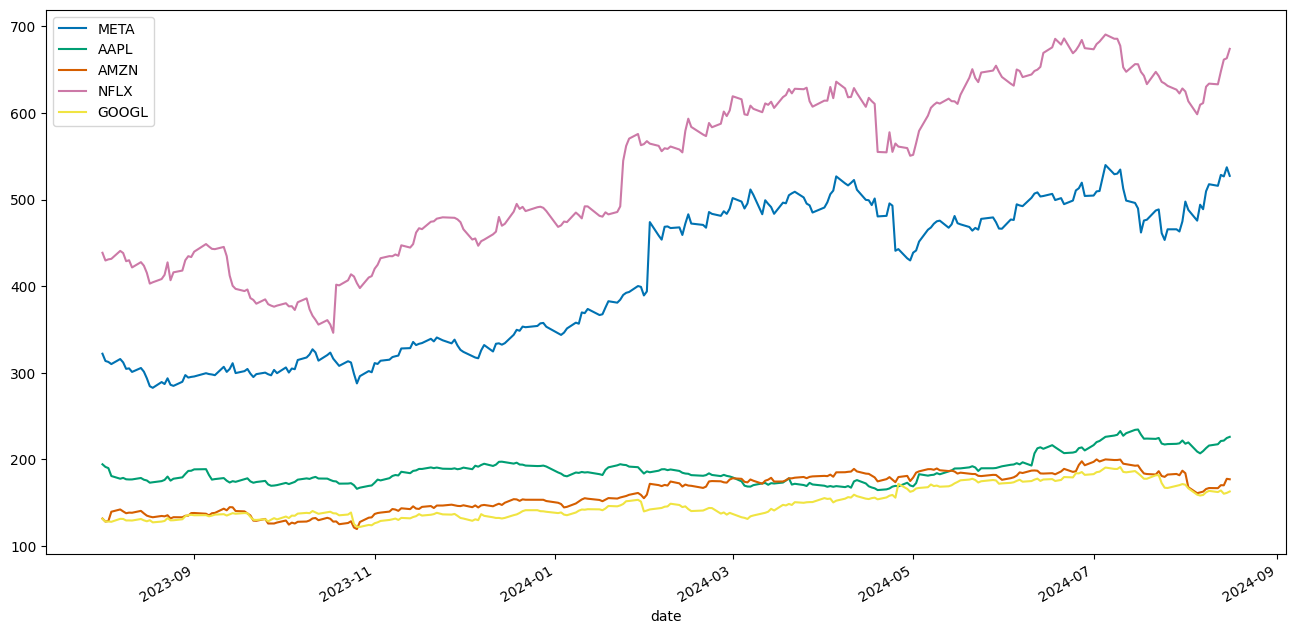

In [5]:
prices_df.plot()

In [6]:
returns_df = prices_to_returns(prices_df)
returns_df

,META,AAPL,AMZN,NFLX,GOOGL
date,,,,,
2023-08-02,-0.026021,-0.015488,-0.026426,-0.020337,-0.024125
2023-08-03,-0.003571,-0.007317,0.005460,0.003025,0.000546
2023-08-04,-0.007871,-0.048015,0.082693,0.001392,-0.002650
2023-08-07,0.018769,-0.017255,0.018987,0.021223,0.026727
2023-08-08,-0.012377,0.005290,-0.016032,-0.005581,-0.000989
...,...,...,...,...,...
2024-08-12,-0.003515,0.007130,-0.000839,-0.001262,-0.008432
2024-08-13,0.024402,0.017193,0.020564,0.023502,0.011523
2024-08-14,-0.003368,0.002034,-0.000764,0.021080,-0.023087


<Axes: title={'center': 'Cumulative Returns'}, xlabel='date'>

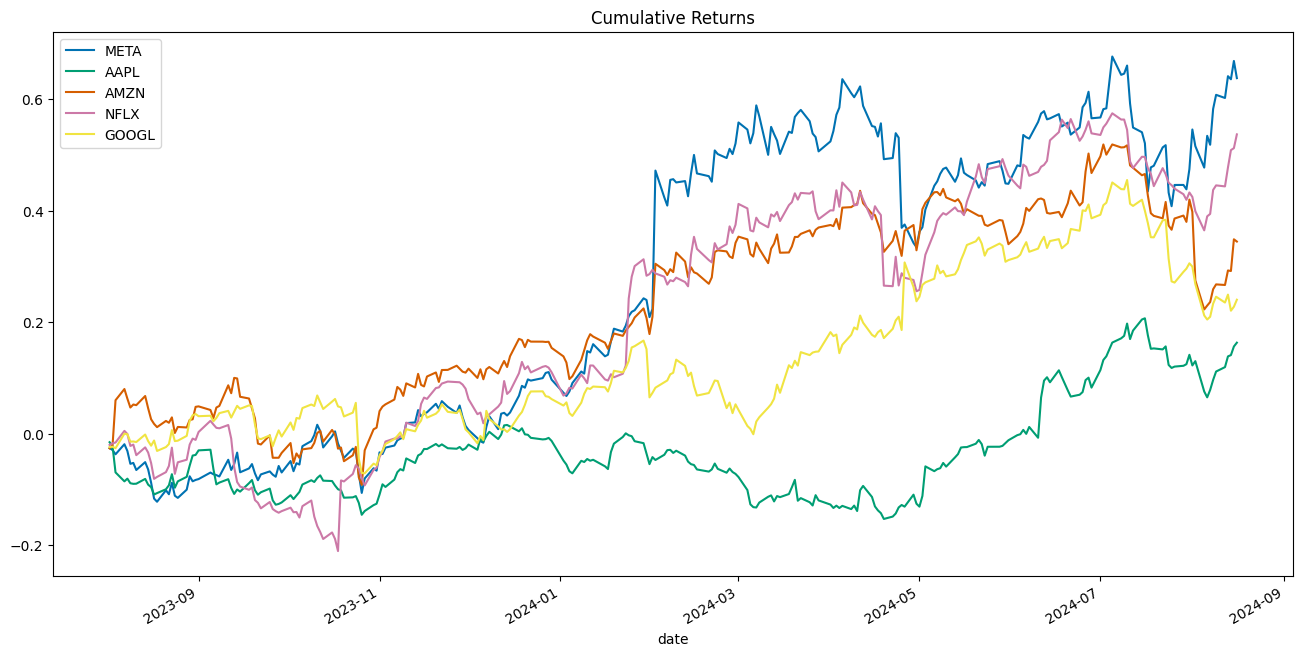

In [7]:
cumulative_returns_df = (1 + returns_df).cumprod() - 1
cumulative_returns_df.plot(title="Cumulative Returns")

## Portfolio Optimization

### Individual portfolios

In [8]:
model = MeanRisk(
    objective_function=ObjectiveFunction.MINIMIZE_RISK,
    risk_measure=RiskMeasure.VARIANCE,
    portfolio_params=dict(name="Min Variance"),
)
model.fit(returns_df)
min_variance_pred = model.predict(returns_df)
model.weights_

array([0.02359533, 0.49553118, 0.16225161, 0.14974249, 0.16887939])

In [11]:
type(min_variance_pred)

skfolio.portfolio._portfolio.Portfolio

In [12]:
model = MeanRisk(
    objective_function=ObjectiveFunction.MAXIMIZE_RETURN,
    portfolio_params=dict(name="Max Return"),
    
)
model.fit(returns_df)
max_return_pred = model.predict(returns_df)


In [13]:
model = MeanRisk(
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    risk_measure=RiskMeasure.VARIANCE,
    portfolio_params=dict(name="Max Sharpe"),
)
model.fit(returns_df)
max_sharpe_pred = model.predict(returns_df)


In [14]:
population = Population([min_variance_pred, max_return_pred, max_sharpe_pred])
population.plot_composition()

In [15]:
population.plot_cumulative_returns()

In [18]:
population.summary()

,Min Variance,Max Return,Max Sharpe
Mean,0.10%,0.21%,0.19%
Annualized Mean,26.13%,53.88%,46.67%
Variance,0.015%,0.054%,0.027%
Annualized Variance,3.81%,13.56%,6.81%
Semi-Variance,0.0083%,0.022%,0.012%
Annualized Semi-Variance,2.10%,5.57%,3.14%
Standard Deviation,1.23%,2.32%,1.64%
Annualized Standard Deviation,19.52%,36.82%,26.09%
Semi-Deviation,0.91%,1.49%,1.12%
Annualized Semi-Deviation,14.50%,23.61%,17.71%


### Efficient Frontier

In [19]:
model = MeanRisk(
    efficient_frontier_size=50,
)
model.fit(returns_df)
efficient_frontier = model.predict(returns_df)

(50, 5)


In [28]:
model.weights_

array([[2.85921893e-02, 4.90063010e-01, 1.60887571e-01, 1.53632764e-01,
        1.66824467e-01],
       [3.93377266e-02, 4.78303883e-01, 1.57990253e-01, 1.61926736e-01,
        1.62441401e-01],
       [5.02460647e-02, 4.66764614e-01, 1.54819736e-01, 1.70179135e-01,
        1.57990451e-01],
       [6.05705918e-02, 4.54855653e-01, 1.52267795e-01, 1.78860471e-01,
        1.53445490e-01],
       [7.13722263e-02, 4.43076786e-01, 1.49353654e-01, 1.87081919e-01,
        1.49115415e-01],
       [8.20367075e-02, 4.31121808e-01, 1.46614767e-01, 1.95361467e-01,
        1.44865251e-01],
       [9.27159874e-02, 4.19349622e-01, 1.43757457e-01, 2.03727308e-01,
        1.40449626e-01],
       [1.03389246e-01, 4.07595237e-01, 1.40890838e-01, 2.12110762e-01,
        1.36013916e-01],
       [1.14056383e-01, 3.95799598e-01, 1.38050500e-01, 2.20478451e-01,
        1.31615068e-01],
       [1.24726787e-01, 3.84024700e-01, 1.35198627e-01, 2.28853146e-01,
        1.27196740e-01],
       [1.35397571e-01, 3.7225

In [27]:
fig = efficient_frontier.plot_measures(
    x=RiskMeasure.ANNUALIZED_VARIANCE,
    y=PerfMeasure.ANNUALIZED_MEAN,
    color_scale=RatioMeasure.ANNUALIZED_SHARPE_RATIO,
    hover_measures=[
        RiskMeasure.MAX_DRAWDOWN, 
        RatioMeasure.ANNUALIZED_SORTINO_RATIO, 
        RiskMeasure.WORST_REALIZATION],
    ]
)
show(fig)


In [24]:
efficient_frontier.plot_composition()

In [25]:
efficient_frontier.measures(measure=RatioMeasure.ANNUALIZED_SHARPE_RATIO)


array([1.35181364, 1.37976504, 1.40686415, 1.4330695 , 1.45834385,
       1.48265366, 1.50597534, 1.52828767, 1.54957519, 1.56982879,
       1.58904413, 1.60722148, 1.62436658, 1.64048932, 1.65560358,
       1.66972711, 1.68288105, 1.69508943, 1.70637856, 1.71677737,
       1.72631615, 1.73502686, 1.74294232, 1.75009615, 1.75652235,
       1.76225511, 1.76732859, 1.77177655, 1.77563234, 1.77892864,
       1.7816974 , 1.78396963, 1.78577542, 1.78714381, 1.78810284,
       1.78867906, 1.78889829, 1.78878496, 1.78836191, 1.78763632,
       1.7866217 , 1.78533897, 1.78336411, 1.77531018, 1.74878207,
       1.70660718, 1.65309376, 1.59243165, 1.52818931, 1.46311468])

In [26]:
efficient_frontier.summary()

,ptf0 - MeanRisk,ptf1 - MeanRisk,ptf2 - MeanRisk,ptf3 - MeanRisk,ptf4 - MeanRisk,ptf5 - MeanRisk,ptf6 - MeanRisk,ptf7 - MeanRisk,ptf8 - MeanRisk,ptf9 - MeanRisk,...,ptf40 - MeanRisk,ptf41 - MeanRisk,ptf42 - MeanRisk,ptf43 - MeanRisk,ptf44 - MeanRisk,ptf45 - MeanRisk,ptf46 - MeanRisk,ptf47 - MeanRisk,ptf48 - MeanRisk,ptf49 - MeanRisk
Mean,0.10%,0.11%,0.11%,0.11%,0.11%,0.12%,0.12%,0.12%,0.12%,0.12%,...,0.19%,0.20%,0.20%,0.20%,0.20%,0.20%,0.21%,0.21%,0.21%,0.21%
Annualized Mean,26.39%,26.95%,27.52%,28.08%,28.64%,29.20%,29.76%,30.32%,30.88%,31.44%,...,48.83%,49.39%,49.95%,50.51%,51.07%,51.64%,52.20%,52.76%,53.32%,53.88%
Variance,0.015%,0.015%,0.015%,0.015%,0.015%,0.015%,0.015%,0.016%,0.016%,0.016%,...,0.030%,0.030%,0.031%,0.032%,0.034%,0.036%,0.040%,0.044%,0.048%,0.054%
Annualized Variance,3.81%,3.82%,3.83%,3.84%,3.86%,3.88%,3.90%,3.94%,3.97%,4.01%,...,7.47%,7.65%,7.85%,8.10%,8.53%,9.15%,9.97%,10.98%,12.17%,13.56%
Semi-Variance,0.0083%,0.0083%,0.0083%,0.0084%,0.0084%,0.0084%,0.0084%,0.0085%,0.0085%,0.0086%,...,0.013%,0.014%,0.014%,0.014%,0.015%,0.016%,0.017%,0.019%,0.020%,0.022%
Annualized Semi-Variance,2.10%,2.10%,2.10%,2.11%,2.11%,2.12%,2.12%,2.13%,2.14%,2.15%,...,3.38%,3.44%,3.51%,3.61%,3.78%,4.02%,4.31%,4.67%,5.08%,5.57%
Standard Deviation,1.23%,1.23%,1.23%,1.23%,1.24%,1.24%,1.24%,1.25%,1.26%,1.26%,...,1.72%,1.74%,1.76%,1.79%,1.84%,1.91%,1.99%,2.09%,2.20%,2.32%
Annualized Standard Deviation,19.52%,19.54%,19.56%,19.59%,19.64%,19.69%,19.76%,19.84%,19.93%,20.03%,...,27.33%,27.67%,28.01%,28.45%,29.21%,30.26%,31.57%,33.13%,34.89%,36.82%
Semi-Deviation,0.91%,0.91%,0.91%,0.91%,0.92%,0.92%,0.92%,0.92%,0.92%,0.92%,...,1.16%,1.17%,1.18%,1.20%,1.23%,1.26%,1.31%,1.36%,1.42%,1.49%
Annualized Semi-Deviation,14.50%,14.50%,14.50%,14.51%,14.53%,14.55%,14.57%,14.60%,14.64%,14.68%,...,18.37%,18.55%,18.73%,19.01%,19.45%,20.04%,20.76%,21.60%,22.54%,23.61%
